In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from keras import layers
from keras import models
from IPython import display

In [5]:
data_dir = pathlib.Path('MonoAudio/TestAudio/SingleNotes')

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.125,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)

def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=256, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

for example_audio, example_labels in train_ds.take(128):  
  print(example_audio.shape)
  print(example_labels.shape)

def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

Found 623 files belonging to 78 classes.
Using 546 files for training.
Using 77 files for validation.
(64, 16000)
(64,)
(64, 16000)
(64,)
(64, 16000)
(64,)
(64, 16000)
(64,)
(64, 16000)
(64,)
(64, 16000)
(64,)
(64, 16000)
(64,)
(64, 16000)
(64,)
(34, 16000)
(34,)


In [47]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_labels),
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model500 = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_labels),
])

model500.summary()

model500.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Input shape: (124, 129, 1)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_16 (Resizing)      (None, 32, 32, 1)         0         
                                                                 
 normalization_5 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_33 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)     

In [48]:
EPOCHS = 100
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/100
9/9 [==============================] - 1s 58ms/step - loss: 4.3574 - accuracy: 0.0165 - val_loss: 4.2902 - val_accuracy: 0.0000e+00
Epoch 2/100
9/9 [==============================] - 0s 43ms/step - loss: 4.2362 - accuracy: 0.0348 - val_loss: 3.9315 - val_accuracy: 0.0000e+00
Epoch 3/100
9/9 [==============================] - 0s 45ms/step - loss: 4.0602 - accuracy: 0.0403 - val_loss: 3.9048 - val_accuracy: 0.0000e+00
Epoch 4/100
9/9 [==============================] - 0s 46ms/step - loss: 3.8778 - accuracy: 0.0568 - val_loss: 3.4701 - val_accuracy: 0.0000e+00
Epoch 5/100
9/9 [==============================] - 0s 47ms/step - loss: 3.6517 - accuracy: 0.0879 - val_loss: 3.1995 - val_accuracy: 0.0769
Epoch 6/100
9/9 [==============================] - 0s 45ms/step - loss: 3.4607 - accuracy: 0.1172 - val_loss: 2.7204 - val_accuracy: 0.1538
Epoch 7/100
9/9 [==============================] - 0s 44ms/step - loss: 3.3713 - accuracy: 0.1136 - val_loss: 3.1547 - val_accuracy: 0.0000e+00


In [8]:
EPOCHS = 500
history500 = model500.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/1000
9/9 [==============================] - 1s 52ms/step - loss: 4.3515 - accuracy: 0.0201 - val_loss: 4.2114 - val_accuracy: 0.0000e+00
Epoch 2/1000
9/9 [==============================] - 0s 44ms/step - loss: 4.1507 - accuracy: 0.0348 - val_loss: 3.8226 - val_accuracy: 0.1538
Epoch 3/1000
9/9 [==============================] - 0s 43ms/step - loss: 3.9268 - accuracy: 0.0586 - val_loss: 3.7132 - val_accuracy: 0.0000e+00
Epoch 4/1000
9/9 [==============================] - 0s 44ms/step - loss: 3.6747 - accuracy: 0.0769 - val_loss: 3.5000 - val_accuracy: 0.0000e+00
Epoch 5/1000
9/9 [==============================] - 0s 42ms/step - loss: 3.4269 - accuracy: 0.1007 - val_loss: 3.1682 - val_accuracy: 0.1538
Epoch 6/1000
9/9 [==============================] - 0s 45ms/step - loss: 3.2420 - accuracy: 0.1392 - val_loss: 3.1632 - val_accuracy: 0.0769
Epoch 7/1000
9/9 [==============================] - 0s 44ms/step - loss: 2.9569 - accuracy: 0.2125 - val_loss: 2.5771 - val_accuracy: 0.2308
E

Text(0, 0.5, 'Accuracy [%]')

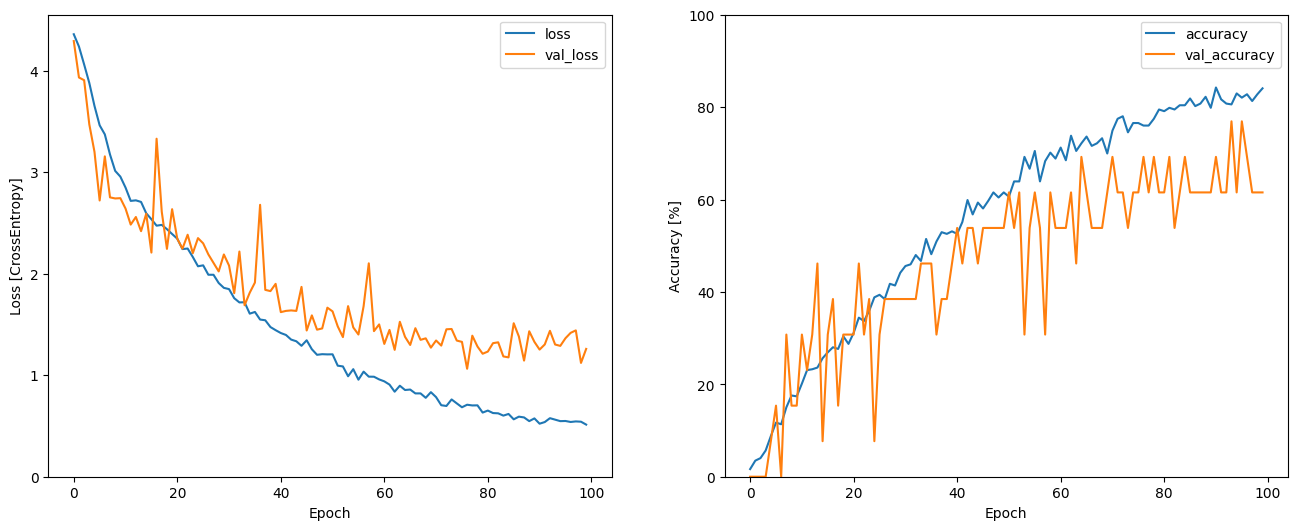

In [49]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [50]:
model.evaluate(test_spectrogram_ds, return_dict=True)

1/1 [==============================] - 0s 31ms/step - loss: 1.6285 - accuracy: 0.5156


{'loss': 1.628509283065796, 'accuracy': 0.515625}

1/1 [==============================] - 0s 47ms/step


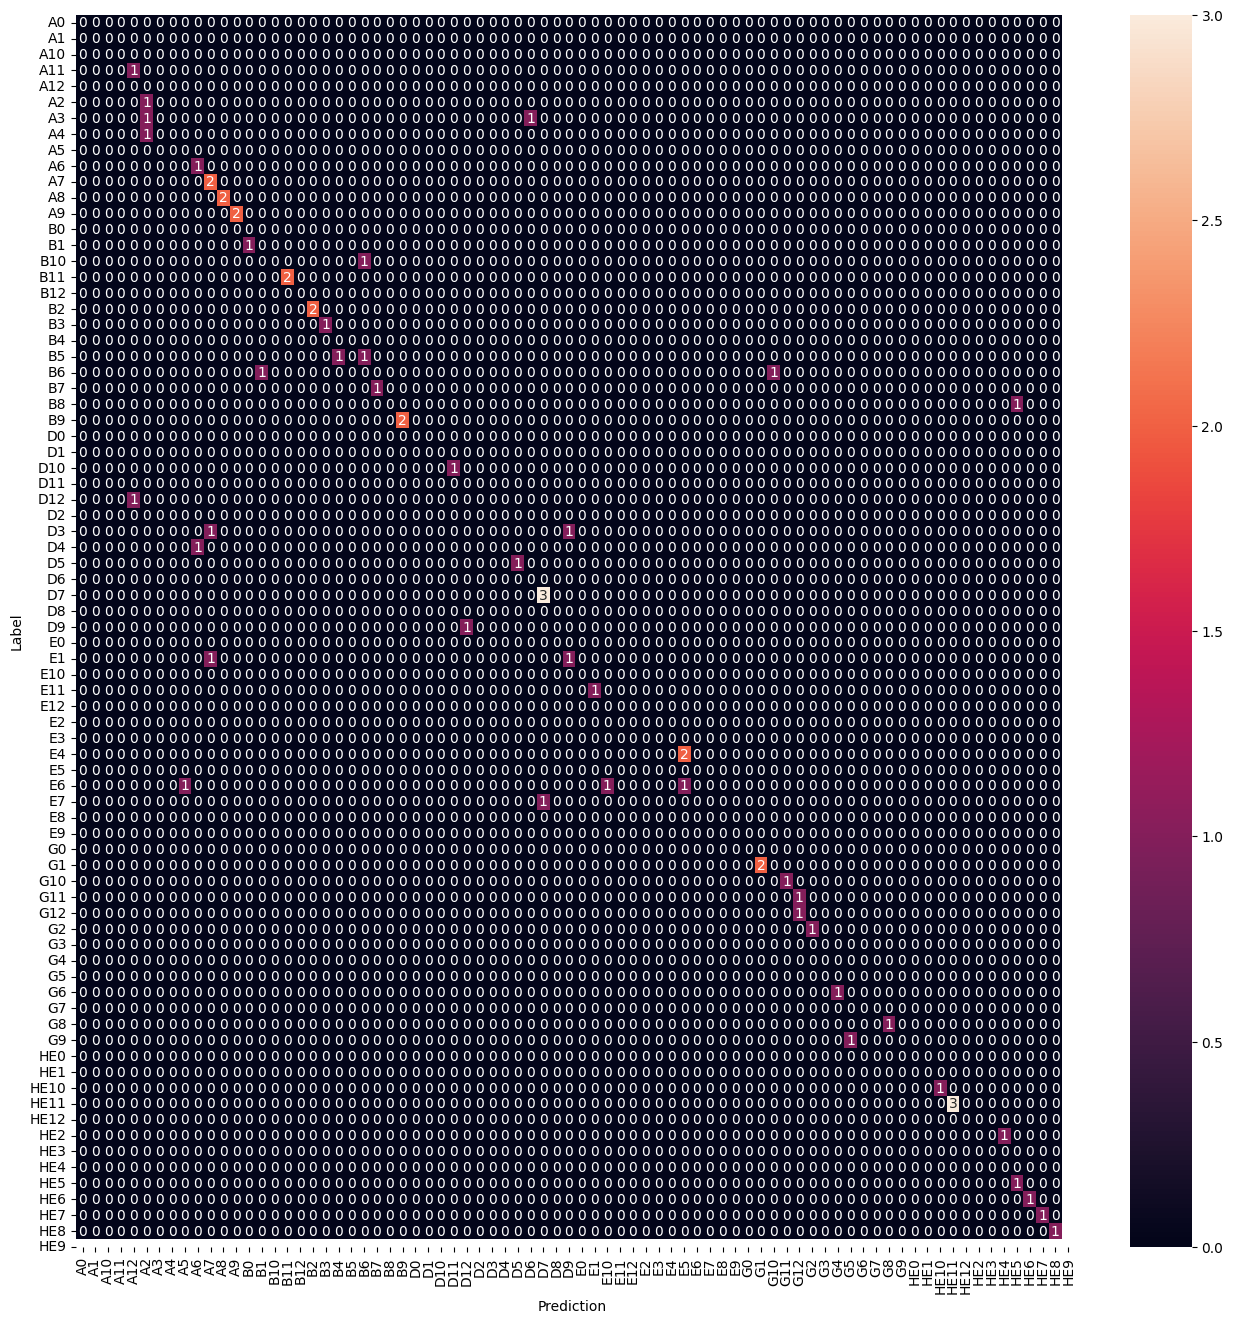

In [51]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16, 16))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Text(0, 0.5, 'Accuracy [%]')

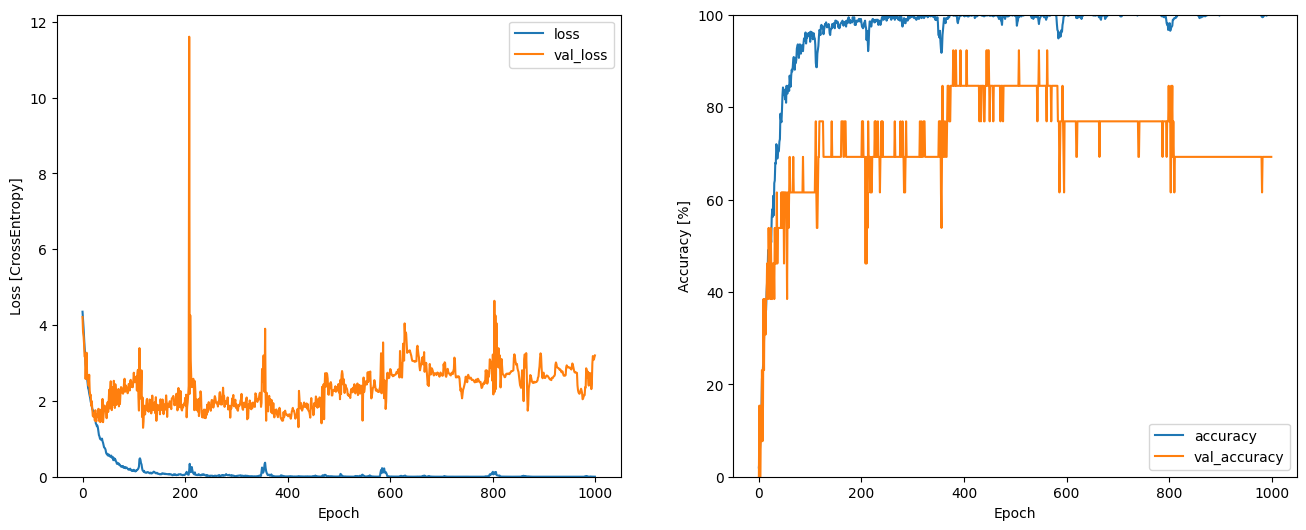

In [12]:
metrics = history500.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history500.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history500.epoch, 500*np.array(metrics['accuracy']), 500*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [13]:
model500.evaluate(test_spectrogram_ds, return_dict=True)

1/1 [==============================] - 0s 17ms/step - loss: 2.8923 - accuracy: 0.6094


{'loss': 2.892300605773926, 'accuracy': 0.609375}

1/1 [==============================] - 0s 46ms/step


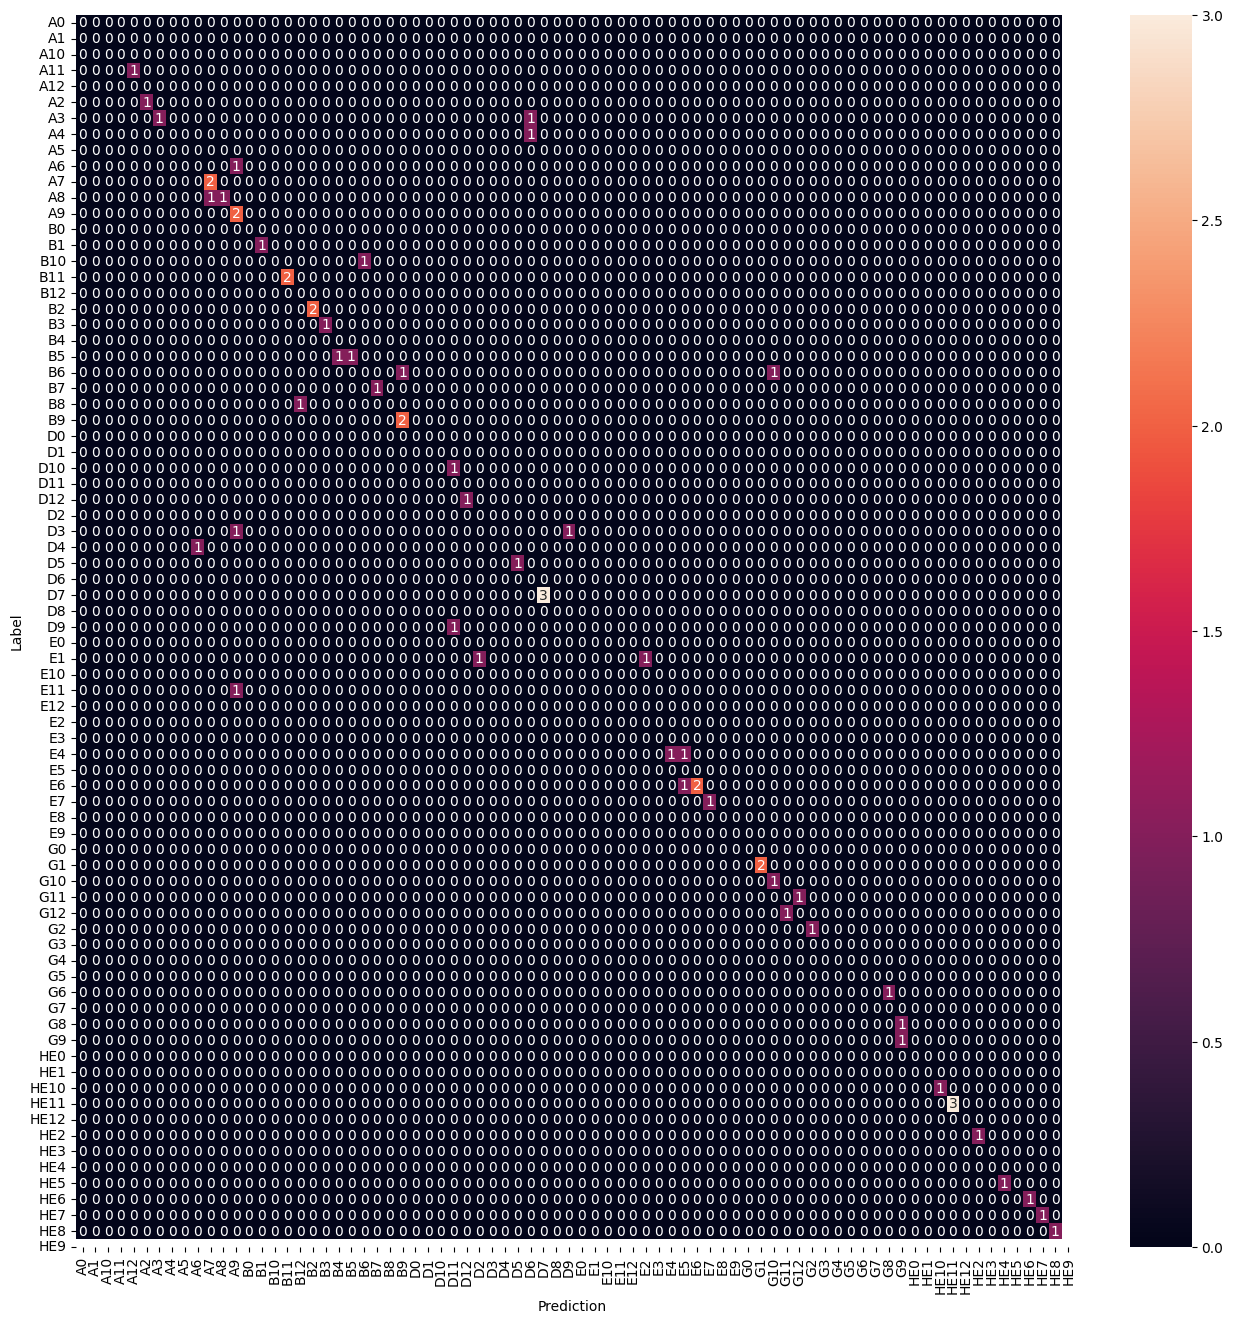

In [14]:
y_pred = model500.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16, 16))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [43]:
model200 = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dropout(0.50),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_labels),
])

model200.summary()

model200.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_15 (Resizing)      (None, 32, 32, 1)         0         
                                                                 
 normalization_4 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 14, 14, 64)      

In [44]:
EPOCHS = 200
history200 = model200.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/200
9/9 [==============================] - 1s 56ms/step - loss: 4.3555 - accuracy: 0.0128 - val_loss: 4.3621 - val_accuracy: 0.0000e+00
Epoch 2/200
9/9 [==============================] - 0s 44ms/step - loss: 4.1929 - accuracy: 0.0366 - val_loss: 4.1329 - val_accuracy: 0.0000e+00
Epoch 3/200
9/9 [==============================] - 0s 44ms/step - loss: 3.9370 - accuracy: 0.0549 - val_loss: 3.7249 - val_accuracy: 0.0000e+00
Epoch 4/200
9/9 [==============================] - 0s 43ms/step - loss: 3.7156 - accuracy: 0.0806 - val_loss: 3.4967 - val_accuracy: 0.0000e+00
Epoch 5/200
9/9 [==============================] - 0s 48ms/step - loss: 3.6110 - accuracy: 0.0916 - val_loss: 3.2288 - val_accuracy: 0.0769
Epoch 6/200
9/9 [==============================] - 0s 46ms/step - loss: 3.3250 - accuracy: 0.1355 - val_loss: 3.0659 - val_accuracy: 0.1538
Epoch 7/200
9/9 [==============================] - 0s 43ms/step - loss: 3.2082 - accuracy: 0.1447 - val_loss: 3.0997 - val_accuracy: 0.0000e+00


Text(0, 0.5, 'Accuracy [%]')

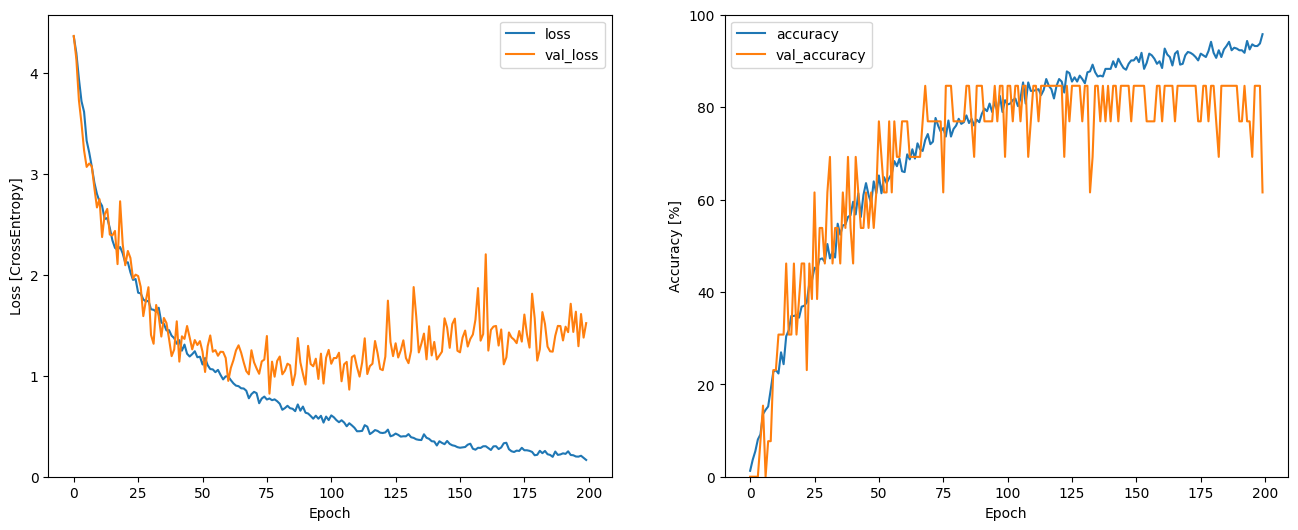

In [45]:
metrics = history200.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history200.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history200.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [46]:
model200.evaluate(test_spectrogram_ds, return_dict=True)

1/1 [==============================] - 0s 18ms/step - loss: 2.2570 - accuracy: 0.5156


{'loss': 2.2570149898529053, 'accuracy': 0.515625}

1/1 [==============================] - 0s 47ms/step


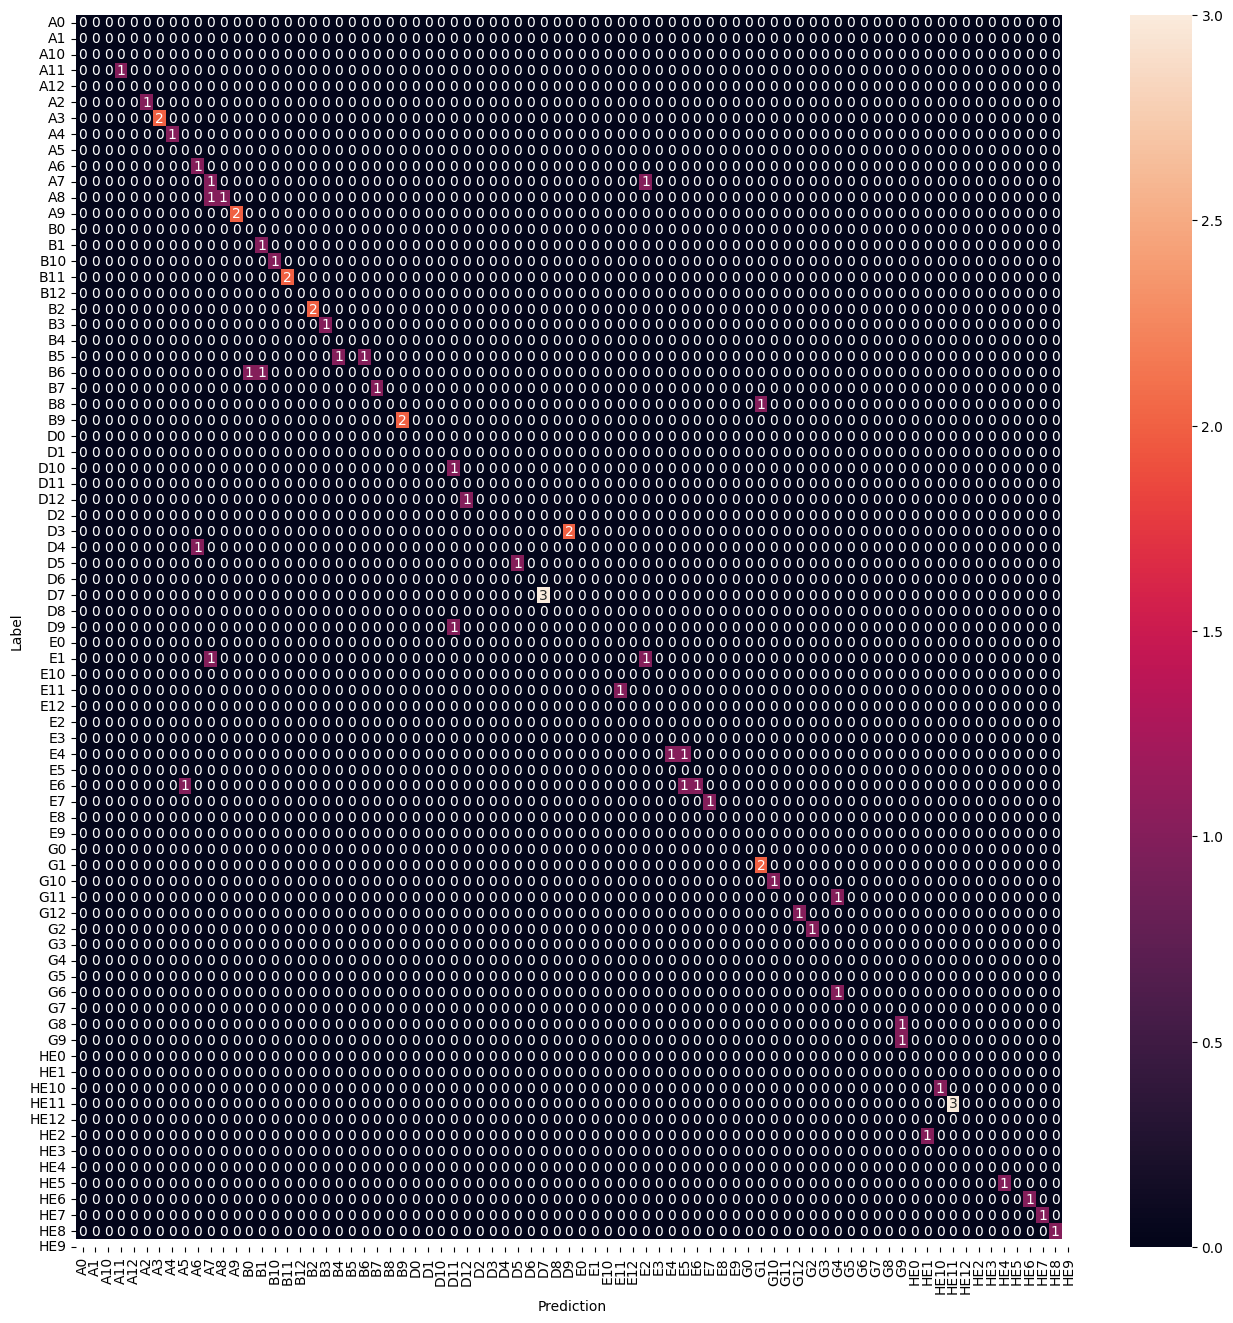

In [52]:
y_pred = model200.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16, 16))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [1]:
model.save("NNModels/100_epoch_model")
model200.save("NNModels/200_epoch_model")
model1000.save("NNModels/1000_epoch_model")

NameError: name 'model' is not defined